In [25]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

RANDOM_STATE = 404

In [26]:
df = pd.read_csv('data/HAD.csv')
df.head()

,AGE,AGE_MISSING,SEX_F,NIHSS_BL,NIHSS_BL_MISSING,SYS_BLOOD_PRESSURE,SYS_BLOOD_PRESSURE_MISSING,PREV_MRS,PREV_MRS_MISSING,ORAL_ANTICOAGULANT,...,ONSET_TO_ADMISSION,ONSET_TO_ADMISSION_MISSING,ONSET_TO_IMAGING,ONSET_TO_IMAGING_MISSING,ONSET_TO_TPA,ONSET_TO_TPA_MISSING,ONSET_TO_GROIN,ONSET_TO_GROIN_MISSING,MRS_90,MRS_90_DICHO
0,70,0,0,3,0,-1,1,0,0,0,...,64,0,96,0,180,0,-1,1,0,0
1,55,0,0,6,0,142,0,3,0,0,...,38,0,104,0,165,0,-1,1,4,1
2,73,0,0,3,0,170,0,0,0,1,...,-1,1,-1,1,-1,1,-1,1,2,0
3,81,0,0,10,0,-1,1,0,0,0,...,69,0,90,0,115,0,-1,1,3,1
4,81,0,1,11,0,-1,1,0,0,0,...,98,0,110,0,120,0,-1,1,0,0


In [27]:
target_feature = 'MRS_90'
y = df.filter([target_feature])
y.to_csv('data/HAD_target.csv', index=False)

#### Because of the warning given while imputing missing values, 'SERUM_GLUCOSE' and 'VALV_HEART' columns are removed due to not having any other entry than '-1' value

In [28]:
df = df.drop(columns={'SERUM_GLUCOSE', 'SERUM_GLUCOSE_MISSING', 'VALV_HEART', 'MRS_90', 'MRS_90_DICHO'}, axis=1)

### Generating missing data based on sklearn imputers

In [29]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# import warnings
# warnings.filterwarnings('ignore')

imputer_df = df.copy()

missing_flag_cols = [col for col in df.columns if col.endswith('_MISSING')]

# imp = SimpleImputer(missing_values=-1, strategy='median')
imp = IterativeImputer(missing_values=-1, initial_strategy='median', random_state=RANDOM_STATE)

# Iterate over columns with missingness flags to heck if imputation is needed and apply imputation only if missingness flag is set to 1
for missing_flag_col in missing_flag_cols:
    value_col = missing_flag_col.replace('_MISSING', '')
    
    if (imputer_df[missing_flag_col] == 1).any():
        imp.fit(imputer_df[[value_col]])
        imputer_df[value_col] = imp.transform(imputer_df[[value_col]]).ravel()
        # # Update missingness flag to 2 for imputed values
        # imputer_df[missing_flag_col] = imputer_df[missing_flag_col].replace(1, 2)

imputer_df = imputer_df[imputer_df.columns.drop(list(imputer_df.filter(regex='MISSING')))]
imputer_df.to_csv('data/HAD_no_missingness.csv', index=False)
imputer_df.head()

,AGE,SEX_F,NIHSS_BL,SYS_BLOOD_PRESSURE,PREV_MRS,ORAL_ANTICOAGULANT,HYPERTENSION,HYPERCHOL,ISCH_HEART,SMOKING,...,OCCLUSION_M2,OCCLUSION_ICA,OCCLUSION_ACA,OCCLUSION_PCA,OCCLUSION_VB,CTA_CS,ONSET_TO_ADMISSION,ONSET_TO_IMAGING,ONSET_TO_TPA,ONSET_TO_GROIN
0,70.0,0,3.0,148.0,0.0,0,1,1,0,1,...,1,0,0,0,0,1.0,64.0,96.0,180.0,217.0
1,55.0,0,6.0,142.0,3.0,0,1,1,0,0,...,-1,-1,-1,-1,-1,1.0,38.0,104.0,165.0,217.0
2,73.0,0,3.0,170.0,0.0,1,1,1,0,0,...,-1,-1,-1,-1,-1,1.0,90.0,116.0,170.0,217.0
3,81.0,0,10.0,148.0,0.0,0,1,0,1,0,...,0,0,0,1,0,1.0,69.0,90.0,115.0,217.0
4,81.0,1,11.0,148.0,0.0,0,1,1,0,0,...,-1,-1,-1,-1,-1,1.0,98.0,110.0,120.0,217.0


### Using BIC to get the optimal number of components for GMM

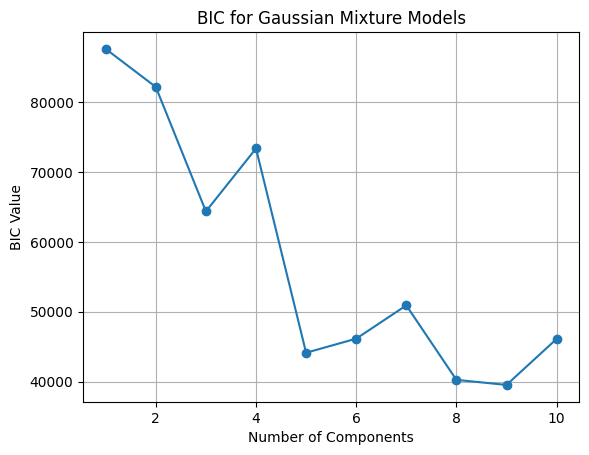

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def compute_bic(X, n_components_range):
    bic = []
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=RANDOM_STATE)
        gmm.fit(X)
        bic.append(gmm.bic(X))
    return bic

n_components_range = range(1, 11)

bic_values = compute_bic(imputer_df, n_components_range)

optimal_n_components = n_components_range[np.argmin(bic_values)]

plt.plot(n_components_range, bic_values, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Value')
plt.title('BIC for Gaussian Mixture Models')
plt.grid(True)
plt.show()

### Gaussian Mixture Model fitting

In [31]:
gmm = GaussianMixture(n_components=optimal_n_components, random_state=RANDOM_STATE)
gmm.fit(imputer_df)

GaussianMixture(n_components=9, random_state=404)

### Generating missing data based on GMM samples

In [32]:
gmm_df = df.copy()

for missing_flag_col in missing_flag_cols:
    value_col = missing_flag_col.replace('_MISSING', '')
    column_index = imputer_df.columns.get_loc(value_col)
    
    for index in range(df.shape[0]):
        if gmm_df.loc[index, missing_flag_col] == 1:
            sample_value = int(gmm.sample(n_samples=1)[0][0][column_index])
            gmm_df.loc[index, value_col] = sample_value
            # # Update missingness flag to 2 for imputed values
            # gmm_df.loc[index, missing_flag_col] = 2
            
gmm_df = gmm_df[gmm_df.columns.drop(list(gmm_df.filter(regex='MISSING')))]          

gmm_df.head()

,AGE,SEX_F,NIHSS_BL,SYS_BLOOD_PRESSURE,PREV_MRS,ORAL_ANTICOAGULANT,HYPERTENSION,HYPERCHOL,ISCH_HEART,SMOKING,...,OCCLUSION_M2,OCCLUSION_ICA,OCCLUSION_ACA,OCCLUSION_PCA,OCCLUSION_VB,CTA_CS,ONSET_TO_ADMISSION,ONSET_TO_IMAGING,ONSET_TO_TPA,ONSET_TO_GROIN
0,70,0,3,152,0,0,1,1,0,1,...,1,0,0,0,0,1,64,96,180,244
1,55,0,6,142,3,0,1,1,0,0,...,-1,-1,-1,-1,-1,1,38,104,165,244
2,73,0,3,170,0,1,1,1,0,0,...,-1,-1,-1,-1,-1,1,108,180,177,244
3,81,0,10,152,0,0,1,0,1,0,...,0,0,0,1,0,1,69,90,115,244
4,81,1,11,152,0,0,1,1,0,0,...,-1,-1,-1,-1,-1,1,98,110,120,244


### Trying to manually sample from the closest distribution

In [33]:
temp_df = df.iloc[:5].copy()
temp_df = temp_df[temp_df.columns.drop(list(temp_df.filter(regex='MISSING')))]

In [34]:
y_pred = gmm.predict(temp_df)
y_pred[0]

6

In [35]:
mean_vector = gmm.means_[y_pred[0]]
covariance_matrix = gmm.covariances_[y_pred[0]]

for missing_flag_col in missing_flag_cols:
    value_col = missing_flag_col.replace('_MISSING', '')
    column_index = imputer_df.columns.get_loc(value_col)

    for index in range(temp_df.shape[0]):
        if df.loc[index, missing_flag_col] == 1:
            manual_sample = np.random.multivariate_normal(mean_vector, covariance_matrix)
            temp_df.loc[index, value_col] = int(manual_sample[column_index])
            
temp_df.head()

,AGE,SEX_F,NIHSS_BL,SYS_BLOOD_PRESSURE,PREV_MRS,ORAL_ANTICOAGULANT,HYPERTENSION,HYPERCHOL,ISCH_HEART,SMOKING,...,OCCLUSION_M2,OCCLUSION_ICA,OCCLUSION_ACA,OCCLUSION_PCA,OCCLUSION_VB,CTA_CS,ONSET_TO_ADMISSION,ONSET_TO_IMAGING,ONSET_TO_TPA,ONSET_TO_GROIN
0,70,0,3,147,0,0,1,1,0,1,...,1,0,0,0,0,1,64,96,180,221
1,55,0,6,142,3,0,1,1,0,0,...,-1,-1,-1,-1,-1,0,38,104,165,231
2,73,0,3,170,0,1,1,1,0,0,...,-1,-1,-1,-1,-1,1,42,68,131,177
3,81,0,10,137,0,0,1,0,1,0,...,0,0,0,1,0,2,69,90,115,179
4,81,1,11,148,0,0,1,1,0,0,...,-1,-1,-1,-1,-1,0,98,110,120,190


In [36]:
concatenated_df = pd.concat([df.head(5), imputer_df.head(5), gmm_df.head(5), temp_df], axis=0)

concatenated_df['source'] = ['df'] * len(df.head(5)) + ['imputer_df'] * len(imputer_df.head(5)) + ['gmm_df'] * len(gmm_df.head(5)) + ['temp_df'] * len(temp_df)

concatenated_df.set_index('source', inplace=True)

concatenated_df.T.to_csv('data/comparison_df.csv')
